In [1]:
import pandas as pd
import numpy as np
import time
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
import tensorflow
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

In [2]:
df = pd.read_csv('train_tp.csv')

In [3]:
df.size

8512

In [4]:
df

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


In [5]:
df.drop(index=[i for i in range(120, 1216)], inplace=True)

In [6]:
display(df)

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
115,178b835e3,16,4,4.2560,3093.750,6.0907,4593.75
116,1795728ba,5,1,39.5680,4781.250,41.9200,10406.20
117,17ca62c97,4,1,32.9173,2343.750,34.7733,4218.75
118,17ca96791,16,4,13.6320,3093.750,15.4667,4593.75


In [7]:
# for fname in df['recording_id']:
#     fname = ''.join(('/train/', fname, '.flac'))
#     !kaggle competitions download -f $fname -c rfcx-species-audio-detection
#     time.sleep(2.5)

In [8]:
sample_num = 0
fname = ''.join((df.recording_id[sample_num], '.flac'))
display(fname)

'003bec244.flac'

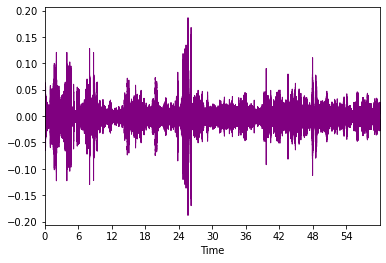

In [9]:
tstart = df.t_min[sample_num]
tend = df.t_max[sample_num]
y, sr = librosa.load(''.join(('train/', fname, '/', fname)))
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple', offset = 0.0)

C:\Users\Andrew\anaconda3\envs\tutorial\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


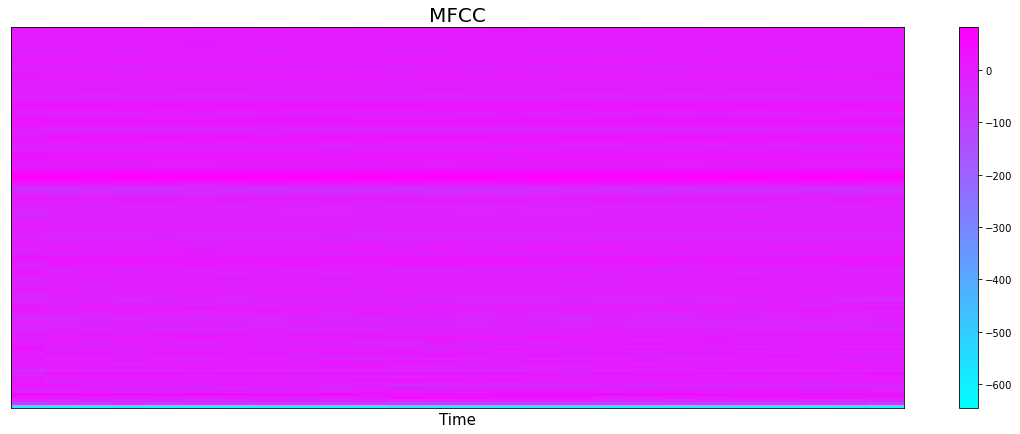

In [10]:
hop_length = 512
n_fft = 255

y_cut = y[int(round(tstart * sr)): int(round(tend * sr))]
MFCCs = librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
fig, ax = plt.subplots(figsize = (20, 7))
librosa.display.specshow(MFCCs, sr=sr, cmap='cool', hop_length=hop_length)

ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)

plt.colorbar()
plt.show()

In [11]:
def padding(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def get_features(df):
    features = []
    labels = []
    for i in range(0, len(df)):
        fname = df.iloc[i]['recording_id'] + '.flac'
        tstart = df.iloc[i]['t_min']
        tend = df.iloc[i]['t_max']
        species_id = df.iloc[i]['species_id']
        try:
            y, sr = librosa.load(''.join(('train/', fname, '/', fname)), sr=28000)
        except:
            print(f'{fname} was not able to be loaded')
            pass
        y_cut = y[int(round(tstart * sr)): int(round(tend * sr))]
        data = np.array(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length, n_mfcc=128))
        features.append(data)
        labels.append(species_id)
    return (features, labels)

In [13]:
x, y = get_features(df)

C:\Users\Andrew\anaconda3\envs\tutorial\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


55088446.flac was not able to be loaded
78788674.flac was not able to be loaded


In [25]:
len(x)

120

In [26]:
X = np.array([padding(i, 128, 450) for i in x])

In [27]:
X.shape

(120, 128, 450)

In [28]:
X = np.array((X - np.min(X)) / (np.max(X) - np.min(X)))
X = X / np.std(X)
y = np.array(y)

In [29]:
X.shape

(120, 128, 450)

In [30]:
y[:10]

array([14, 23, 12, 17, 10,  8,  0, 18, 15,  1], dtype=int64)

In [79]:
x_train, x_test = X[:100], X[101:]
y_train, y_test = y[:100], y[101:]

In [33]:
x_train.shape

(100, 128, 450)

In [61]:
print(x_train[0])

[[23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]
 [23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]
 [23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]
 ...
 [23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]
 [23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]
 [23.831715 23.831715 23.831715 ... 23.831715 23.831715 23.831715]]


In [111]:
Y_train = np.array([[1 if i == j else 0 for i in range(128)] for j in y_train])

In [112]:
Y_test = np.array([[1 if i == j else 0 for i in range(128)] for j in y_test])

In [113]:
model = 0
input_shape=(128,450)
model = tensorflow.keras.Sequential()
model.add(Dense(32,input_shape=input_shape))
model.add(Dense(24, activation='softmax'))

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128, 32)           14432     
_________________________________________________________________
dense_28 (Dense)             (None, 128, 24)           792       
Total params: 15,224
Trainable params: 15,224
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = model.fit(x_train, Y_train, epochs=5)

Epoch 1/5
4/4 [==============================] - 1s 10ms/step - loss: 81.4303 - acc: 0.0397
Epoch 2/5
4/4 [==============================] - 0s 9ms/step - loss: 0.6391 - acc: 0.9921
Epoch 3/5
4/4 [==============================] - 0s 6ms/step - loss: 1.2527 - acc: 0.9922
Epoch 4/5
4/4 [==============================] - 0s 11ms/step - loss: 1.5898 - acc: 0.9922
Epoch 5/5
4/4 [==============================] - 0s 6ms/step - loss: 1.7641 - acc: 0.9922


In [118]:
preds = model.predict(x_test)

In [119]:
preds.shape

(19, 128, 24)

In [117]:
loss, acc = model.evaluate(x_test, Y_test)

1/1 [==============================] - 0s 268ms/step - loss: 1.8341 - acc: 0.9922
